This notebook is based off a [Kaggle competition](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction) for predicting NYC taxi fares.

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../../Data/NYCTaxiFares.csv')

In [3]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [4]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

In [5]:
# Calculate the distances traveled
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [6]:
df["dist_km"] = haversine_distance(
    df,
    "pickup_latitude",
    "pickup_longitude",
    "dropoff_latitude",
    "dropoff_longitude",
)


In [7]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
pickup_datetime      120000 non-null object
fare_amount          120000 non-null float64
fare_class           120000 non-null int64
pickup_longitude     120000 non-null float64
pickup_latitude      120000 non-null float64
dropoff_longitude    120000 non-null float64
dropoff_latitude     120000 non-null float64
passenger_count      120000 non-null int64
dist_km              120000 non-null float64
dtypes: float64(6), int64(2), object(1)
memory usage: 8.2+ MB


In [9]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
pickup_datetime      120000 non-null datetime64[ns, UTC]
fare_amount          120000 non-null float64
fare_class           120000 non-null int64
pickup_longitude     120000 non-null float64
pickup_latitude      120000 non-null float64
dropoff_longitude    120000 non-null float64
dropoff_latitude     120000 non-null float64
passenger_count      120000 non-null int64
dist_km              120000 non-null float64
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


In [11]:
my_time = df['pickup_datetime'][0]

In [12]:
my_time.hour

8

In [13]:
# Create a column for local time (NYC)
df['edt_date'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

In [14]:
df['hour'] = df['edt_date'].dt.hour

In [15]:
df['am_or_pm'] = np.where(df['hour'] < 12, 'am', 'pm')

In [16]:
df['day_of_week'] = df['edt_date'].dt.strftime('%a')

In [17]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,edt_date,hour,am_or_pm,day_of_week
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


In [18]:
# Separate categorical and continuous columns
cat_cols = ["hour", "am_or_pm", "day_of_week"]
cont_cols = [
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count",
    "dist_km",
]


In [19]:
y_col = ['fare_amount']

In [20]:
# Let's convert our categorical columns to the `category` type
# https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
edt_date             datetime64[ns, UTC]
hour                               int64
am_or_pm                          object
day_of_week                       object
dtype: object

In [21]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [22]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
edt_date             datetime64[ns, UTC]
hour                            category
am_or_pm                        category
day_of_week                     category
dtype: object

In [23]:
# Note the final line - a finite number of possibilities is listed (categorical)
df['hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [24]:
df['am_or_pm'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: am_or_pm, dtype: category
Categories (2, object): [am, pm]

In [25]:
df['day_of_week'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [26]:
hr = df['hour'].cat.codes.values
ampm = df['am_or_pm'].cat.codes.values
wkdy = df['day_of_week'].cat.codes.values

In [27]:
hr

array([ 4, 11,  7, ..., 14,  4, 12], dtype=int8)

In [28]:
cats = np.stack([hr,ampm,wkdy],axis=1)

In [29]:
cats

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  1,  2]], dtype=int8)

In [30]:
# One-line we could have used instead of everything above
# cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)

In [31]:
cats = torch.tensor(cats, dtype=torch.int64)

In [32]:
# Convert continuous vars into pytorch tensor
conts = np.stack([df[col].values for col in cont_cols], axis=1)

In [33]:
conts

array([[-73.992365  ,  40.730521  , -73.975499  ,  40.744746  ,
          1.        ,   2.12631159],
       [-73.990078  ,  40.740558  , -73.974232  ,  40.744114  ,
          1.        ,   1.39230687],
       [-73.994149  ,  40.751118  , -73.960064  ,  40.766235  ,
          2.        ,   3.32676344],
       ...,
       [-73.988574  ,  40.749772  , -74.011541  ,  40.707799  ,
          3.        ,   5.05252282],
       [-74.004449  ,  40.724529  , -73.992697  ,  40.730765  ,
          1.        ,   1.20892296],
       [-73.955415  ,  40.77192   , -73.967623  ,  40.763015  ,
          3.        ,   1.42739869]])

In [34]:
conts = torch.tensor(conts, dtype=torch.float)

In [35]:
conts

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,   3.0000,   5.0525],
        [-74.0044,  40.7245, -73.9927,  40.7308,   1.0000,   1.2089],
        [-73.9554,  40.7719, -73.9676,  40.7630,   3.0000,   1.4274]])

In [36]:
# Convert y label to tensor
y = torch.tensor(df[y_col].values, dtype=torch.float)

In [37]:
y

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [12.5000],
        [ 4.9000],
        [ 5.3000]])

Let's examine our tensors.

In [38]:
cats.shape

torch.Size([120000, 3])

In [39]:
conts.shape

torch.Size([120000, 6])

In [40]:
y.shape

torch.Size([120000, 1])

In [41]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]

In [42]:
# 24 hrs/day, am/pm, 7 days in a week
cat_szs

[24, 2, 7]

In [43]:
# Set embedding sizes based off these categories
embed_sizes = [(size,min(50,(size+1)//2)) for size in cat_szs] # Size shouldn't exceed 50 (+1 in case there are 2 cats)

In [44]:
embed_sizes

[(24, 12), (2, 1), (7, 4)]

Next, let's define a tabular model and set up our network.

The model we're going to use can be applied to a variety of problems using a similar dataset.

In [45]:
catz = cats[:4]

In [46]:
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [47]:
# After embedding
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embed_sizes])


In [48]:
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [49]:
# Forward method (catz)
embeddingz = []

for i, e in enumerate(selfembeds):
    embeddingz.append(e(catz[:, i]))


In [50]:
embeddingz

[tensor([[ 0.0136, -0.6046, -1.0130,  0.1357, -0.1872, -1.6564,  0.2605,  0.5173,
          -0.5118, -0.2442, -0.4844, -0.4975],
         [ 0.0961,  0.7261, -2.1117, -1.6093, -0.2166,  1.4961, -0.1521,  0.0839,
          -1.0550, -0.4637, -0.6699, -0.5009],
         [-0.9589,  1.2709,  1.6983, -1.8480, -0.2609, -0.0975,  0.1053, -0.5263,
          -1.1077,  1.2925, -0.4712,  0.3201],
         [-0.4149, -1.2320, -0.3628,  0.5659,  1.4116,  0.6014,  0.5710,  0.7102,
           0.2547, -0.5243, -1.3138, -0.3986]], grad_fn=<EmbeddingBackward>),
 tensor([[0.0142],
         [0.0142],
         [0.0142],
         [0.0343]], grad_fn=<EmbeddingBackward>),
 tensor([[-0.2345, -1.5073, -1.1545, -0.6044],
         [-0.5590,  1.9176,  0.0237,  0.7398],
         [-0.5590,  1.9176,  0.0237,  0.7398],
         [-1.5803, -0.0360, -0.5950, -0.7257]], grad_fn=<EmbeddingBackward>)]

In [51]:
z = torch.cat(embeddingz, 1)


In [52]:
z

tensor([[ 0.0136, -0.6046, -1.0130,  0.1357, -0.1872, -1.6564,  0.2605,  0.5173,
         -0.5118, -0.2442, -0.4844, -0.4975,  0.0142, -0.2345, -1.5073, -1.1545,
         -0.6044],
        [ 0.0961,  0.7261, -2.1117, -1.6093, -0.2166,  1.4961, -0.1521,  0.0839,
         -1.0550, -0.4637, -0.6699, -0.5009,  0.0142, -0.5590,  1.9176,  0.0237,
          0.7398],
        [-0.9589,  1.2709,  1.6983, -1.8480, -0.2609, -0.0975,  0.1053, -0.5263,
         -1.1077,  1.2925, -0.4712,  0.3201,  0.0142, -0.5590,  1.9176,  0.0237,
          0.7398],
        [-0.4149, -1.2320, -0.3628,  0.5659,  1.4116,  0.6014,  0.5710,  0.7102,
          0.2547, -0.5243, -1.3138, -0.3986,  0.0343, -1.5803, -0.0360, -0.5950,
         -0.7257]], grad_fn=<CatBackward>)

In [53]:
selfembdrop = nn.Dropout(0.4) # randomly turns off 40% of neurons to prevent overfitting
z = selfembdrop(z)

In [54]:
z

tensor([[ 0.0000, -0.0000, -1.6883,  0.2261, -0.3120, -2.7607,  0.4341,  0.8622,
         -0.8530, -0.4070, -0.8074, -0.0000,  0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000],
        [ 0.1601,  1.2102, -0.0000, -0.0000, -0.3609,  0.0000, -0.2535,  0.0000,
         -1.7583, -0.0000, -1.1165, -0.8348,  0.0000, -0.0000,  0.0000,  0.0395,
          0.0000],
        [-1.5982,  0.0000,  2.8305, -3.0801, -0.0000, -0.1625,  0.0000, -0.0000,
         -0.0000,  0.0000, -0.7853,  0.0000,  0.0236, -0.9316,  3.1961,  0.0000,
          1.2329],
        [-0.6916, -0.0000, -0.6047,  0.9431,  2.3526,  0.0000,  0.9516,  0.0000,
          0.4244, -0.8739, -2.1897, -0.6643,  0.0000, -2.6338, -0.0600, -0.9916,
         -1.2095]], grad_fn=<MulBackward0>)

Let's create a TabularModel class to automate this work.

In [57]:
class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []
        n_emb = sum([nf for ni, nf in emb_szs])
        n_in = n_emb + n_cont

        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1], out_sz))

        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        embeddings = []

        for i, e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:, i]))

        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)

        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        
        return x


In [58]:
torch.manual_seed(33)
model = TabularModel(embed_sizes, conts.shape[1], 1, [200, 100], 0.4)


In [59]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [60]:
criterion = nn.MSELoss() # np.sqrt(MSE) -> RMSE
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [61]:
# cut data into two batches
batch_size = 60000
test_size = int(batch_size * 0.2)


In [62]:
# Data shuffled already - must be shuffled before train/test split
cat_train = cats[: batch_size - test_size]
cat_test = cats[batch_size - test_size : batch_size]
con_train = conts[: batch_size - test_size]
con_test = conts[batch_size - test_size : batch_size]


In [63]:
y_train = y[: batch_size - test_size]
y_test = y[batch_size - test_size : batch_size]


In [64]:
len(cat_train)

48000

In [65]:
len(con_train)

48000

In [66]:
len(cat_test)

12000

In [67]:
# Set up training model
import time

start_time = time.time()
epochs = 300
losses = []
for i in range(epochs):
    i += 1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train))  # Loss measured with #RMSE
    losses.append(loss)

    if i % 10 == 1:
        print(f"Epoch: {i}, loss is {loss}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

duration = time.time() - start_time
print(f"Training took {duration / 60} minutes")


Epoch: 1, loss is 12.500558853149414
Epoch: 11, loss is 12.160984992980957
Epoch: 21, loss is 11.738170623779297
Epoch: 31, loss is 11.323526382446289
Epoch: 41, loss is 10.903594017028809
Epoch: 51, loss is 10.48028564453125
Epoch: 61, loss is 10.078513145446777
Epoch: 71, loss is 9.706099510192871
Epoch: 81, loss is 9.366927146911621
Epoch: 91, loss is 9.055986404418945
Epoch: 101, loss is 8.731254577636719
Epoch: 111, loss is 8.393117904663086
Epoch: 121, loss is 8.01679515838623
Epoch: 131, loss is 7.609460830688477
Epoch: 141, loss is 7.187142848968506
Epoch: 151, loss is 6.718173027038574
Epoch: 161, loss is 6.239473342895508
Epoch: 171, loss is 5.744353294372559
Epoch: 181, loss is 5.258383274078369
Epoch: 191, loss is 4.800900459289551
Epoch: 201, loss is 4.36135721206665
Epoch: 211, loss is 4.014267444610596
Epoch: 221, loss is 3.761172294616699
Epoch: 231, loss is 3.618586540222168
Epoch: 241, loss is 3.5245437622070312
Epoch: 251, loss is 3.4927680492401123
Epoch: 261, loss 

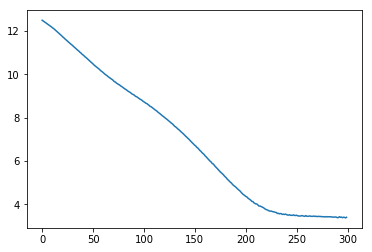

In [69]:
# Plot out our loss function
plt.plot(range(epochs), losses);

Now that we've trained the model, it's time to validate it on our test set.